# 應用多變量分析 HW6
### 105024519 許閔翔

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import svd
import IPython.core.display as di

di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [12]:
df = pd.read_csv("cluster.csv", sep = ",")
del df["Unnamed: 0"]
df.head()

,school,clu,control
0,Remington College-Dallas Campus,1,2
1,University of New Mexico-Taos Campus,2,1
2,Le Cordon Bleu College of Culinary Arts-Miami,1,3
3,Washtenaw Community College,1,1
4,Sierra College,1,1


In [23]:
table = pd.crosstab(index = df["clu"], columns = df["control"], margins = True)

table.columns = ["con1","con2","con3","tol_pred"]
table.index= ["clu1","clu2","clu3","clu4","clu5","tol_con"]

print("The contingency table")
table

The contingency table


,con1,con2,con3,tol_pred
clu1,28,2,10,40
clu2,7,2,1,10
clu3,2,3,9,14
clu4,18,4,1,23
clu5,13,0,0,13
tol_con,68,11,21,100


In [24]:
table_pro = table/table.ix["tol_con","tol_pred"]
table_pro

,con1,con2,con3,tol_pred
clu1,0.28,0.02,0.10,0.40
clu2,0.07,0.02,0.01,0.10
clu3,0.02,0.03,0.09,0.14
clu4,0.18,0.04,0.01,0.23
clu5,0.13,0.00,0.00,0.13
tol_con,0.68,0.11,0.21,1.00


In [25]:
table_row = table.div(table["tol_pred"], axis=0)
del table_row["tol_pred"]
table_row["ri"] = table_pro.tol_pred

print("The row profiles")
table_row

The row profiles


,con1,con2,con3,ri
clu1,0.700000,0.050000,0.250000,0.40
clu2,0.700000,0.200000,0.100000,0.10
clu3,0.142857,0.214286,0.642857,0.14
clu4,0.782609,0.173913,0.043478,0.23
clu5,1.000000,0.000000,0.000000,0.13
tol_con,0.680000,0.110000,0.210000,1.00


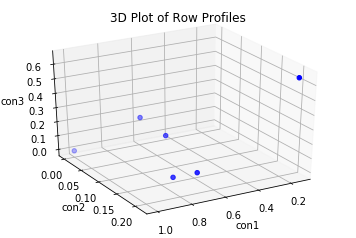

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.set_xlabel('con1')
ax.set_ylabel('con2')
ax.set_zlabel('con3')
ax.scatter(table_row.con1, table_row.con2, table_row.con3, c = 'b', marker = 'o')
angle = 60
ax.view_init(30, angle)

plt.title("3D Plot of Row Profiles")
plt.show()

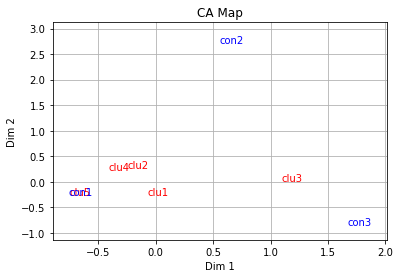

In [28]:
class CA(object):
    """Simple corresondence analysis.
    
    Inputs
    ------
    ct : array_like
      Two-way contingency table. If `ct` is a pandas DataFrame object,
      the index and column values are used for plotting.
    """

    def __init__(self, ct):
        self.rows = ct.index.values if hasattr(ct, 'index') else None
        self.cols = ct.columns.values if hasattr(ct, 'columns') else None
        
        # contingency table
        N = np.matrix(ct, dtype=float)

        # correspondence matrix from contingency table
        P = N / N.sum()

        # row and column marginal totals of P as vectors
        r = P.sum(axis=1)
        c = P.sum(axis=0).T

        # diagonal matrices of row/column sums
        D_r_rsq = np.diag(1. / np.sqrt(r.A1))
        D_c_rsq = np.diag(1. / np.sqrt(c.A1))

        # the matrix of standarized residuals
        S = D_r_rsq * (P - r * c.T) * D_c_rsq

        # compute the SVD
        U, D_a, V = svd(S, full_matrices=False)
        D_a = np.asmatrix(np.diag(D_a))
        V = V.T

        # principal coordinates of rows ############################
        F = D_r_rsq * U * D_a

        # principal coordinates of columns
        G = D_c_rsq * V * D_a

        # standard coordinates of rows
        X = D_r_rsq * U

        # standard coordinates of columns ##########################
        Y = D_c_rsq * V

        # the total variance of the data matrix
        inertia = sum([(P[i,j] - r[i,0] * c[j,0])**2 / (r[i,0] * c[j,0])
                       for i in range(N.shape[0])
                       for j in range(N.shape[1])])

        self.F = F.A
        self.G = G.A
        self.X = X.A
        self.Y = Y.A
        self.inertia = inertia
        self.eigenvals = np.diag(D_a)**2

    def plot(self):
        """Plot the first and second dimensions."""
        xmin, xmax = None, None
        ymin, ymax = None, None
        if self.rows is not None:
            for i, t in enumerate(self.rows):
                x, y = self.F[i,0], self.F[i,1]
                plt.text(x, y, t, va='center', ha='center', color='r')
                xmin = min(x, xmin if xmin else x)
                xmax = max(x, xmax if xmax else x)
                ymin = min(y, ymin if ymin else y)
                ymax = max(y, ymax if ymax else y)
        else:
            plt.plot(self.F[:, 0], self.F[:, 1], 'ro')

        if self.cols is not None:
            for i, t in enumerate(self.cols):
                x, y = self.Y[i,0], self.Y[i,1]
                plt.text(x, y, t, va='center', ha='center', color='b')
                xmin = min(x, xmin if xmin else x)
                xmax = max(x, xmax if xmax else x)
                ymin = min(y, ymin if ymin else y)
                ymax = max(y, ymax if ymax else y)
        else:
            plt.plot(self.Y[:, 0], self.y[:, 1], 'bs')

        if xmin and xmax:
            pad = (xmax - xmin) * 0.1
            plt.xlim(xmin - pad, xmax + pad)
        if ymin and ymax:
            pad = (ymax - ymin) * 0.1
            plt.ylim(ymin - pad, ymax + pad)

        plt.grid()
        plt.xlabel('Dim 1')
        plt.ylabel('Dim 2')

def _test():
    import pandas as pd

    df = pd.read_csv("cluster.csv", sep = ",")
    del df["Unnamed: 0"]
    table = pd.crosstab(index = df["clu"], columns = df["control"], margins = False)
    table.columns = ["con1","con2","con3"]#,"tol_pred"]
    table.index= ["clu1","clu2","clu3","clu4","clu5"]#,"tol_con"]

    ca = CA(table)

    plt.figure(100)
    ca.plot()

    plt.title("CA Map")
    plt.show()
    
if __name__ == '__main__':
    _test()